In [155]:
# Todo: make more like get-r in that it should accept args and save to disk; far easier to parallelise that way
# (MSessions don't play nicely with threads, apparently)

In [1]:
# Set up environment
using Pkg
Pkg.activate(".")
Pkg.instantiate()

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`


In [2]:
# Todo: remove unused ones
import JSON
import Base.Iterators
using Base.Threads # make sure you run with env JULIA_NUM_THREADS=8 julia (or whatever number you want)
# BLAS.set_num_threads(8) # unset and restart kernel before doing any multithreaded work in Julia
#using SparseArrays
using ThreadedMap
# using BenchmarkTools
using Query
#import ProgressMeter
import LightGraphs
import Plots
using JuliaDB
#import IterTools
import GZip
using Serialization
#using MATLAB
using TensorDecompositions: CANDECOMP
import SparseArrays
# using JSONTables
import StatsBase
import RollingFunctions

In [158]:
# Gs = deserialize("/home/olie/.dropbox-work/OED/adj-mats/synonymy.jls")

# adj has entries of 2 for self-loops. should probably remove these?
# would also be interesting to see what happens as one increased the distance at which we considered things synonyms (e.g. go up one category)
# uses approx 1.5GB of ram for 15 timesteps; ergo 300 would want about 30GB. Is that enough? Probably.


# This stuff is mostly in oed_decomp.jl now

#  mat"""
#  addpath decomp/matlab
#  addpath decomp/matlab/tensor_toolbox
#  """

# function matlab_load_sptensor(adj_mats)
#     sparsefloat(am1) =
#         convert(SparseArrays.SparseMatrixCSC{Float64,Int64}, am1)
#     adj_mats = map(sparsefloat, adj_mats)
#     mat"spt = sparse_matrix_list_to_sptensor($adj_mats)"
# end
# 
# "Convert dict from matlab to CANDECOMP struct"
# function _matlab_dict_to_cp(D, r)
#     if r == 1
#         lmbda = Array{Float64}(undef, r)
#         lmbda .= D["lambda"]
#         # Make it a 10x1 array, not a 10x0 array
#         factors = map(permutedims ∘ permutedims, D["u"]|>Tuple)
#         CANDECOMP(factors, lmbda)
#     else
#         CANDECOMP(D["u"]|>Tuple, D["lambda"])
#     end
# end
# 
# """
#     ncp(r, method="apg")
# 
# 'apg' is the 'apg-tf' method from Xu and Yin 2013.
# 
# """
# function matlab_ncp_loaded_spt(r, method="apg")
#     if method == "apg"
#         mat"$D = ncp_apg(spt, $r, {});"
#     end
#     _matlab_dict_to_cp(D, r)
# end
# 
# function relerror_loaded(D)
#     D = Dict(("lambda" => D.lambdas, "u" => Any[D.factors...]))
#     mat"relerror(spt, $D)"
# end
# 
# matlab_nncp_loaded_spt(r) = matlab_ncp_loaded_spt(r, "apg")

# s = size.(Gs)
# matlab_load_sptensor([g[1:s[i][1],1:s[i][2]] for (i,g) in enumerate(Gs)])

# by far easiest way to parallelise this is to have this whole notebook be a script that writes to disk
# as starting multiple MATLAB sessions is complicated
# This doesn't take much RAM but it does take quite a while, 10s of mins
# Should store these as they are finished
# Ds = [matlab_nncp_loaded_spt(i) for i in 2:2:10]

In [159]:
;ls

decomp
Ds.jls
errors_in_the_wild.md
Manifest.toml
oed_crawler.ipynb
oed_decomp.ipynb
oed_decomp.jl
oed.gz
oed_network_maker.ipynb
oed_words_per_year.pdf
oed_words_per_year_region.pdf
Project.toml
sketch.md


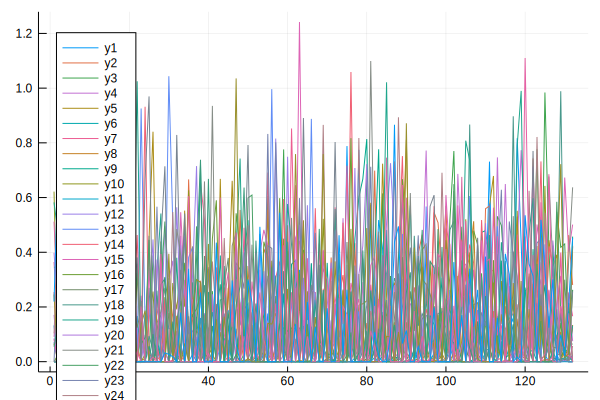

In [19]:
# R2-repeats-1.jls looks OK, but others look dodgy
#Ds = deserialize("R2-repeats-1.jls")
Ds = deserialize("/home/olie/.dropbox-work/OED/decomps/SemanticR31-repeats-1.jls")
Ds[1].factors[3] # time is third factor
# This is worryingly noisy;
# Perhaps we need to add another layer for semantic hierarchy
# or increase the number of levels we consider synonyms (just one didn't help much)
# OTOH: some of these lines look pretty sensible

# Should also look at how to label stuff - should serialise the table to make querying easy
Plots.plot(Ds[1].factors[3]; legend=:topleft)

132×11 Array{Float64,2}:
 0.0          0.0         0.0         …  0.0          0.0537368   0.0      
 0.0          0.0         0.0            0.0          0.0         0.0      
 0.0          0.0         0.00288044     0.0          0.0         2.49321  
 0.0          0.0         0.0            1.14027      0.0         0.0      
 0.0          0.0         0.0            0.0          0.0         0.134714 
 0.000191964  0.00241989  0.0         …  0.0          0.214887    0.0      
 0.0          0.0         0.0            0.0          0.0         0.0      
 0.0          0.0         0.0            0.167513     0.0         1.12562  
 0.0          0.0         0.0            0.0          0.0         0.573724 
 0.0          0.0         0.00184057     0.0915675    0.0         0.665357 
 0.0          7.62291e-5  0.00161157  …  0.000331009  9.6948e-5   8.2321e-6
 0.0          0.0         0.00381764     0.258916     0.0         0.285609 
 0.0          0.0         0.0            0.225034     0.0064798

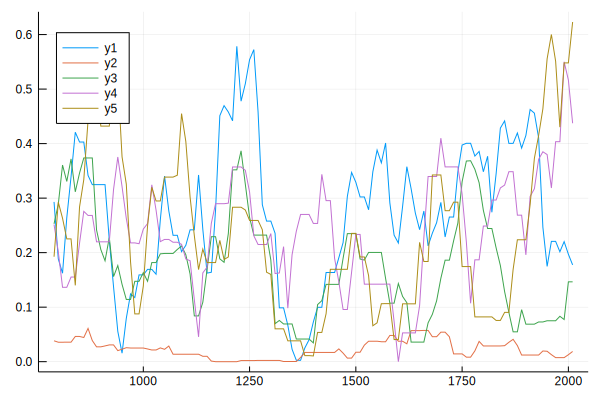

In [3]:
#Ds = deserialize("/home/olie/.dropbox-work/OED/decomps/R11-repeats-1.jls")
Ds = deserialize("/home/olie/.dropbox-work/OED/decomps/SemanticR11-repeats-1.jls")
# perhaps we should just cut out the noisy ones?
# could eliminate those with lowest autocorrelation
# http://juliastats.github.io/StatsBase.jl/latest/signalcorr/#StatsBase.autocor
ordering = sortperm(StatsBase.autocor(Ds[1].factors[3])[2,:],rev=true)
#D_sorted = Ds[1].factors[3][:,ordering]

window = 10
stepping = 10
years = (700+(window-1)*stepping):stepping:2014
# Doesn't seem much better tbh :(
Plots.plot(years,RollingFunctions.rollmean.(eachcol(Ds[1].factors[3][:,ordering[1:5]]),window); legend=:topleft)

# 11 sort of looks OK if we smooth it a lot!

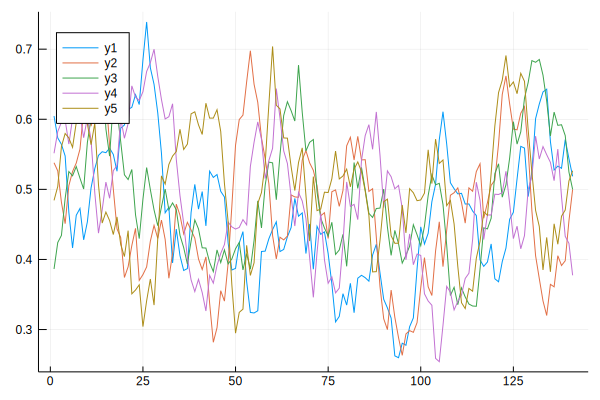

In [63]:
# "Control"
dummy = rand(150,30)
ordering = sortperm(StatsBase.autocor(dummy)[2,:],rev=true)

# Doesn't seem much better tbh :(
Plots.plot(RollingFunctions.rollmean.(eachcol(dummy[:,ordering[1:5]]),10); legend=:topleft)

In [266]:
ordering # i.e. the 9th column is the second best one

11-element Array{Int64,1}:
  1
  9
  8
  6
  3
 11
  4
 10
  5
  7
  2

In [4]:
oed_table = deserialize("/home/olie/.dropbox-work/OED/oed_table.jls")

Table with 828971 rows, 20 columns:
Columns:
#   colname             type
────────────────────────────────────────────────────────
1   part_of_speech      Union{Nothing, String}
2   quotation_ids       Array{Any,1}
3   synonymy_classes    Array{T,1} where T
4   main_current_sense  Bool
5   first_use           Union{Nothing, String}
6   id                  String
7   transitivity        Union{Nothing, Dict{String,Any}}
8   daterange           Dict{String,Any}
9   semantic_class_ids  Array{Any,1}
10  definition          Union{Nothing, String}
11  meta                Dict{String,Any}
12  oed_url             String
13  word_id             String
14  lemma               String
15  oed_reference       String
16  categories          Dict{String,Any}
17  start               Int64
18  end                 Union{Nothing, Int64}
19  obsolete            Bool
20  node_id             Int64

In [14]:
classes = select(oed_table, :semantic_class_ids) |> Iterators.flatten |> Iterators.flatten |> unique
class2node = Dict(v => k for (k,v) in enumerate(classes));
node2class = Dict(v => k for (k,v) in class2node)
node2classf = x -> node2class[x]

#31 (generic function with 1 method)

233461

In [92]:
firstword = minimum(select(oed_table,:node_id))
Ds[1].factors[1][firstword:end,:] # Why is factors 2 classes only and not words?
bestwords = sortperm.(eachcol(Ds[1].factors[1][firstword:end,:]),rev=true);
shortlist = hcat([b[1:5] for b in bestwords]...)
words = [
    (oed_table |> @filter(_.node_id in shortlist[:,i]) |> @select(:lemma,:quotation_ids) |> @orderby_descending(length(_.quotation_ids)) |> collect)
for i in 1:(size(Ds[1].factors[3])[2])]
labels = [reduce((a,b)->a*", "*b, get.(w, :lemma, "")[1:3]) for w in words]

828970×11 Array{Float64,2}:
 0.0         0.000112782  0.0          …  0.0          0.0  0.0       
 0.00407937  0.00602222   0.0             0.0          0.0  0.00701171
 0.011923    0.0054974    0.00962228      0.0          0.0  0.0033259 
 0.0028669   0.0118568    0.000697377     0.0          0.0  0.00607403
 0.0052719   0.00262142   0.003111        0.000259934  0.0  0.0       
 0.0         0.00239367   0.0          …  0.0061862    0.0  0.00207601
 0.00118713  0.00229096   0.00405105      0.0039466    0.0  0.0015766 
 0.00286847  0.0          0.00394184      0.0          0.0  0.0       
 0.0         0.00507964   0.0             0.00100273   0.0  0.0061928 
 0.00542715  0.00467529   0.0             0.0          0.0  0.0       
 0.00789576  0.00553662   0.0          …  0.0126298    0.0  5.33365e-5
 0.00879171  0.00266466   0.00742983      0.0150111    0.0  0.00493849
 0.00362937  0.00751774   0.0             0.000237001  0.0  0.0       
 ⋮                                     ⋱         

In [15]:
# to name based on words rather than categories just need to only look at rows corresponding to words (i.e. min node_id:end)
bestclasses = sortperm.(eachcol(Ds[1].factors[2]),rev=true);
shortlist = hcat([b[1:5] for b in bestclasses]...)
#labels = [reduce((a,b)->a*", "*b, get.(w, :lemma, "")[1:3]) for w in words]
labels = [reduce((a,b)->a*", "*b, node2classf.(c)[1:3]) for c in eachcol(shortlist)]

11-element Array{String,1}:
 "202424, 137814, 146770"
 "126228, 218412, 146733"
 "85755, 191145, 194167" 
 "113578, 28459, 31084"  
 "91092, 74589, 149465"  
 "34369, 139742, 231309" 
 "36909, 51548, 157565"  
 "117076, 234168, 166349"
 "171652, 166083, 84409" 
 "80031, 167980, 70257"  
 "68016, 118169, 6256"   

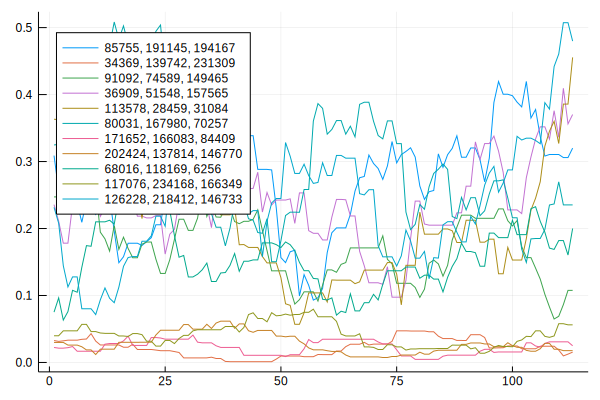

In [16]:
# These don't seem to make much sense
# words in the same group seem totally unrelated
# I think we have messed up something somewhere
# bugger

# instead could look at top classes, find words that belong to those classes,
# (need to work out how to go from node id to class id - not sure we preserve this info)
# pick the ones with the most quotations

# or include mini OED lookup in here to find class name

# If none of that works, plan B is to look at multilayer network

num2plot = 11 
Plots.plot(RollingFunctions.rollmean.(eachcol(Ds[1].factors[3][:,ordering[1:num2plot]]),20); legend=:topleft,labels=labels[ordering[1:num2plot]])

# 85755 -> not completing one's business
# 191145 -> graphic representation by means of computer
# 194167 -> method of naming a written character (e.g. the letter 'a')

# this is all just nonsense, isn't it.
# bugger

# I guess now we get to play the "is it a bug or is it real" game
# bugger

In [359]:
#Plots.savefig("oed_decomp_firstgo.pdf")